# Homework 1

## Instructions

First, ensure you have cloned the [course repository](https://github.com/lydiaYchen/DDL25Spring).

Then, open the [interactive notebook version](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/homework-1.ipynb) of this homework from your local copy.

For part A, fill in the code and answers within the notebook and save your changes.

For part B, create and archive the necessary Python/shell scripts together.

Finally, upload the notebook and the archive to the assignment in ILIAS.

## Part A (12 points)

### Note

When not otherwise specified, use the following parameter values in experiment runs:
- `nr_clients` (N): 100
- `lr`: 0.01
- `client_fraction` (C): 0.1
- `nr_local_epochs` (E): 1
- `batch_size` (B): 100
- `nr_rounds`: 10
- `iid`: True

For all exercises, pass `seed = 10` to calls for splitting data, server initialization, or plotting.

In [1]:
import pandas as pd
import seaborn as sns
#from tutorial_1a.hfl_complete import *

n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 10
iid = True
seed = 10

### Exercise A1: FedSGD with weights (3 points)

#### Question

_(2 points)_ Implement a version of FedSGD that uses weights in its updates, like FedAvg, instead of the gradients from the version of the tutorials. The two FedSGD versions should have the same test accuracy after each round (with a tolerance of at most 0.02%). To show this, compare their output for the following two scenarios over *5 rounds*:
- `lr = 0.01, client_subsets = split(100, True, ...), client_fraction = 0.5`
- `lr = 0.1, client_subsets = split(50, False, ...), client_fraction = 0.2`

*Tip:* You can use the existing FedAvg implementation to minimize the amount of code writing required.

_(1 point)_ Explain in which cases (about the different parameters for decentralized learning) the two are equivalent.

## Dataset & Dataloader

Import necessary libraries.

Define the path to the data directory and a Greek letter symbol.

Check for available hardware (CUDA or MPS) and set the device accordingly.

Ensure deterministic behavior for reproducibility.

Define a transformation pipeline to convert images to tensors and normalize them.

Load the MNIST training and test datasets with the defined transformations and create data loaders for them.

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the path to the data dir
data_path = "./data"
# Define the Greek small letter eta symbol
ETA = "\N{GREEK SMALL LETTER ETA}"

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")



#Reproductibility
torch.backends.cudnn.deterministic = True

transform = transforms.Compose([
    transforms.ToTensor(),
    # normalize by training set mean and standard deviation
    # resulting data has mean=0 and std=1
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST training dataset with the defined transformations
train_dataset = datasets.MNIST(data_path, train=True, download=True, transform=transform)
# Load the MNIST test dataset with the defined transformations
test_loader = DataLoader(
    datasets.MNIST(data_path, train=False, download=False, transform=transform),
    # Set the batch size to 10000 for testing
    batch_size=10000,
    # Shuffle the data (not necessary for testing)
    shuffle=False,
    # Do not drop the last incomplete batch
    drop_last=False,
    # Use a specific generator to avoid reproducibility issues
    generator=torch.Generator()
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.00MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 309kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.44MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.55MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## Model

In [3]:
import torch.nn as nn
import torch.nn.functional as F


# Define a class for the MNIST CNN model
class MnistCnn(nn.Module):
    def __init__(self):
        super(MnistCnn, self).__init__()

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # Define the first dropout layer with a dropout probability of 0.25
        self.dropout1 = nn.Dropout(0.25)
        # Define the second dropout layer with a dropout probability of 0.5
        self.dropout2 = nn.Dropout(0.5)
        # Define the first fully connected layer
        self.fc1 = nn.Linear(9216, 128)
        # Define the second fully connected layer
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation
        x = self.conv1(x)
        x = F.relu(x)
        # Apply the second convolutional layer followed by ReLU activation
        x = self.conv2(x)
        x = F.relu(x)
        # Apply max pooling with a kernel size of 2
        x = F.max_pool2d(x, 2)
        # Apply the first dropout layer
        x = self.dropout1(x)
        # Flatten the tensor
        x = torch.flatten(x, 1)
        # Apply the first fully connected layer followed by ReLU activation
        x = self.fc1(x)
        x = F.relu(x)
        # Apply the second dropout layer
        x = self.dropout2(x)
        # Apply the second fully connected layer
        x = self.fc2(x)
        # Apply log softmax activation
        output = F.log_softmax(x, dim=1)

        return output

## Training

In [4]:
from torch.optim import Optimizer

def train_epoch(model: torch.nn.Module, loader: DataLoader, optimizer: Optimizer) -> None:
    # Set the model to training mode
    model.train()

    # Iterate over the data loader
    for data, target in loader:
        # Move data and target to the specified device (CPU, CUDA, or MPS)
        data, target = data.to(device), target.to(device)
        # Zero the gradients of the optimizer
        optimizer.zero_grad()
        # Perform a forward pass through the model
        output = model(data)
        # Calculate the negative log-likelihood loss
        loss = F.nll_loss(output, target)
        # Perform a backward pass to compute gradients
        loss.backward()
        # Update the model parameters using the optimizer
        optimizer.step()
    return

## Split

In [5]:
from typing import cast

import numpy as np
import numpy.random as npr
from torch.utils.data import Subset

# Subset for each party
# iid, some clients has specific class of data -> clients has 2 classes each instaed of from every classes
def split(nr_clients: int, iid: bool, seed: int) -> list[Subset]:
    rng = npr.default_rng(seed)

    if iid:
        splits = np.array_split(rng.permutation(len(train_dataset)), nr_clients)
    else:
        sorted_indices = np.argsort(np.array([target for _data, target in train_dataset])) #separate by classes
        shards = np.array_split(sorted_indices, 2 * nr_clients) # each client, at most 2 labels
        shuffled_shard_indices = rng.permutation(len(shards)) # shuffle the shards
        splits = [
            np.concatenate([shards[i] for i in inds], dtype=np.int64)
            for inds in shuffled_shard_indices.reshape(-1, 2)] #iterate through the shards and concatenate them to assign to clients

    return [Subset(train_dataset, split) for split in cast(list[list[int]], splits)] #return the subsets, cast to list of list of int for needed type


sample_split = split(100, True, 42)

##RunResult
data class RunResult that is used to store and monitor the results of training a machine learning model

In [6]:
from dataclasses import asdict, dataclass, field

from pandas import DataFrame

# auxiliare class to monitor the training
# each rounds, subset will be trained and tested (otherwise lots of communication)
# the results will be stored in the RunResult class

@dataclass
class RunResult:
    algorithm: str
    n: int  # number of clients
    c: float  # client_fraction
    b: int  # take -1 as inf
    e: int  # nr_local_epochs
    lr: float  # printed as lowercase eta
    seed: int
    wall_time: list[float] = field(default_factory=list) #simulation of time takek
    message_count: list[int] = field(default_factory=list)
    test_accuracy: list[float] = field(default_factory=list)

    def as_df(self, skip_wtime=True) -> DataFrame:
        self_dict = {
            k.capitalize().replace("_", " "): v
            for k, v in asdict(self).items()}

        if self_dict["B"] == -1:
            self_dict["B"] = "\N{INFINITY}"

        df = DataFrame({"Round": range(1, len(self.wall_time) + 1), **self_dict})
        df = df.rename(columns={"Lr": ETA})
        if skip_wtime:
            df = df.drop(columns=["Wall time"])
        return df

## Client Server Class
Abstract base classes for client and server

In [7]:
from abc import ABC, abstractmethod

class Client(ABC):
    def __init__(self, client_data: Subset, batch_size: int) -> None:
        self.model = MnistCnn().to(device)
        self.generator = torch.Generator()
        self.loader_train = DataLoader(
            client_data, batch_size=batch_size, shuffle=True,
            drop_last=False, generator=self.generator)


    @abstractmethod
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        ...


class Server(ABC):
    def __init__(self, lr: float, batch_size: int, seed: int) -> None:
        self.clients: list[Client]
        self.lr = lr
        self.batch_size = batch_size
        self.seed = seed
        torch.manual_seed(seed)
        self.model = MnistCnn().to(device) #local copy of model


    @abstractmethod
    def run(self, nr_rounds: int) -> RunResult:
        ...


    def test(self) -> float:
        correct = 0
        self.model.eval()

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = self.model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        return 100. * correct / len(cast(datasets.MNIST, test_loader.dataset))

##Centralized server

class is used to train a machine learning model in a centralized manner, where all data is available on a single server

In [8]:
from time import perf_counter

from torch.optim import SGD
from tqdm import tqdm


class CentralizedServer(Server):
    def __init__(self, lr: float, batch_size: int, seed: int) -> None:
        super().__init__(lr, batch_size, seed)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.generator = torch.Generator()
        self.loader_train = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True,
            drop_last=False, generator=self.generator)
        self.clients = []

    def run(self, nr_rounds: int) -> RunResult:

        elapsed_time = 0.
        run_result = RunResult("Centralized", 1, 1, self.batch_size, 1, self.lr, self.seed)

        for epoch in tqdm(range(nr_rounds), desc="Epochs", leave=False):
            start_time = perf_counter()
            self.generator.manual_seed(self.seed + epoch + 1)
            train_epoch(self.model, self.loader_train, self.optimizer)
            elapsed_time += perf_counter() - start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(0) # no communication, since centralized
            run_result.test_accuracy.append(self.test())

        return run_result

In [9]:
centralized_server = CentralizedServer(0.5, 1024, 42)
result_centralized = centralized_server.run(5)
centralized_df = result_centralized.as_df()
centralized_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,Centralized,1,1,1024,1,0.5,42,0,88.36
1,2,Centralized,1,1,1024,1,0.5,42,0,92.49
2,3,Centralized,1,1,1024,1,0.5,42,0,97.35
3,4,Centralized,1,1,1024,1,0.5,42,0,97.66
4,5,Centralized,1,1,1024,1,0.5,42,0,98.33


## Decentralized Server

In [10]:
class DecentralizedServer(Server):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, seed: int) -> None:
        super().__init__(lr, batch_size, seed)
        self.nr_clients = len(client_subsets)
        self.client_fraction = client_fraction
        self.client_sample_counts = [len(subset) for subset in client_subsets]
        self.nr_clients_per_round = max(1, round(client_fraction * self.nr_clients))
        self.rng = npr.default_rng(seed)

In [11]:
class GradientClient(Client):
    def __init__(self, client_data: Subset) -> None:
        super().__init__(client_data, len(client_data))

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights): #client and server values together
                client_values[:] = server_values
                client_values.grad = None #set grad to 0

        # seeding is not strictly necessary here
        self.generator.manual_seed(seed)
        self.model.train()

        # this will always have one iteration (infinity batch size)
        for data, target in self.loader_train:
            data, target = data.to(device), target.to(device)
            output = self.model(data)
            loss = F.nll_loss(output, target)
            loss.backward() #calculate gradients

        return [
            cast(torch.Tensor, x.grad).detach().cpu().clone() #detach and duplicate from graph because no need to calculate gradients (normally through machines)
            for x in self.model.parameters()] #return the gradients to the server


##FedSgdGradientServer
class implements a federated learning algorithm where clients compute gradients based on their local data and send these gradients back to the server. The server then aggregates these gradients to update the global model.

In [12]:
class FedSgdGradientServer(DecentralizedServer):
    def __init__(
            self, lr: float,
            client_subsets: list[Subset], client_fraction: float, seed: int) -> None:
        super().__init__(lr, -1, client_subsets, client_fraction, seed)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr) #need optimizer because gradient
        self.clients = [GradientClient(subset) for subset in client_subsets]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(
            "FedSGDGradient", self.nr_clients, self.client_fraction, -1, 1, self.lr, self.seed)

        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            self.optimizer.zero_grad()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False) #find active clients
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients) #total nb of samples from clients
            chosen_adjusted_gradients: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round #controlled variability
                client_gradients = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_gradients.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_gradients])
                update_time = max(update_time, perf_counter() - update_start_time) #simulate parallel training

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_chosen_gradients: list[torch.Tensor] = [
                torch.stack(x, dim=0).sum(dim=0) for x in zip(*chosen_adjusted_gradients)] #average the gradients once all clients have updated

            with torch.no_grad():
                zip_gradient_parameter = zip(averaged_chosen_gradients, self.model.parameters())
                for client_gradient, server_parameter in zip_gradient_parameter:
                    server_parameter.grad = client_gradient.to(device=device) #copy average gardient to our models

            self.optimizer.step() #update the weights
            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [13]:
fedsgd_gradient_server = FedSgdGradientServer(0.02, sample_split, 0.2, 42)
result_fedsgd_gradient = fedsgd_gradient_server.run(5)
fedsgd_gradient_df = result_fedsgd_gradient.as_df()
fedsgd_gradient_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGDGradient,100,0.2,∞,1,0.02,42,40,8.89
1,2,FedSGDGradient,100,0.2,∞,1,0.02,42,80,9.47
2,3,FedSGDGradient,100,0.2,∞,1,0.02,42,120,10.31
3,4,FedSGDGradient,100,0.2,∞,1,0.02,42,160,12.56
4,5,FedSGDGradient,100,0.2,∞,1,0.02,42,200,15.72


## FedAvgServer
weightClient class updates the client's model parameters based on the received weights and trains the model for a specified number of epochs. The FedAvgServer class manages the training process by aggregating the weights from multiple clients and updating the global model

In [14]:
class WeightClient(Client):
    def __init__(self, client_data: Subset, lr: float, batch_size: int, nr_epochs: int) -> None:
        super().__init__(client_data, batch_size)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.nr_epochs = nr_epochs


    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        self.generator.manual_seed(seed)

        for _epoch in range(self.nr_epochs):
            train_epoch(self.model, self.loader_train, self.optimizer)

        return [x.detach().cpu().clone() for x in self.model.parameters()]


class FedAvgServer(DecentralizedServer):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, nr_local_epochs: int, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        self.name = "FedAvg"
        self.nr_local_epochs = nr_local_epochs
        self.clients = [
            WeightClient(subset, lr, batch_size, nr_local_epochs)
            for subset in client_subsets]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(
            self.name, self.nr_clients, self.client_fraction, self.batch_size,
            self.nr_local_epochs, self.lr, self.seed)

        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients) #total nb of samples from clients, bc clients data not same amount
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_chosen_weights: list[torch.Tensor] = [
                torch.stack(x, dim=0).sum(dim=0) for x in zip(*chosen_adjusted_weights)]

            with torch.no_grad():
                zip_weight_parameter = zip(averaged_chosen_weights, self.model.parameters())
                for client_weight, server_parameter in zip_weight_parameter:
                    server_parameter[:] = client_weight.to(device=device)
                    #no optimizer since we have weights

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [15]:
fedavg_server = FedAvgServer(0.02, 200, sample_split, 0.2, 1, 42)
result_fedavg = fedavg_server.run(5)
fedavg_df = result_fedavg.as_df()
fedavg_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,1,0.02,42,40,10.33
1,2,FedAvg,100,0.2,200,1,0.02,42,80,25.84
2,3,FedAvg,100,0.2,200,1,0.02,42,120,41.47
3,4,FedAvg,100,0.2,200,1,0.02,42,160,54.87
4,5,FedAvg,100,0.2,200,1,0.02,42,200,62.81


#### Answer

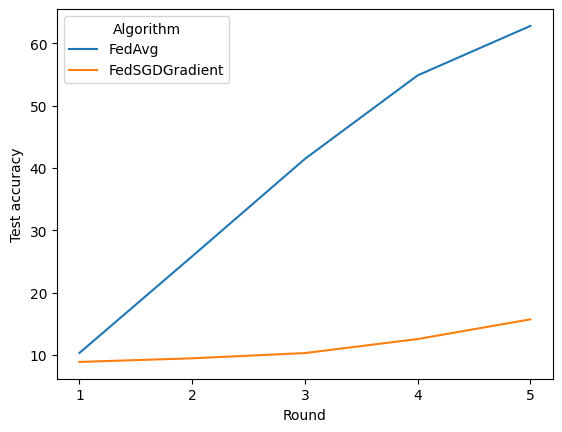

In [16]:
import pandas as pd
import seaborn as sns

df = pd.concat([fedavg_df, fedsgd_gradient_df], ignore_index=True)
ax = sns.lineplot(df, x="Round", y="Test accuracy", hue="Algorithm", seed=0)
_ = ax.set_xticks(df["Round"].unique())

In [17]:
class FedSgdWServer(DecentralizedServer):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, nr_local_epochs: int, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        self.name = "Fedsgdw"
        self.nr_local_epochs = 1
        self.batch_size = b
        self.clients = [
            WeightClient(subset, lr, batch_size, nr_local_epochs)
            for subset in client_subsets]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(
            self.name, self.nr_clients, self.client_fraction, self.batch_size,
            self.nr_local_epochs, self.lr, self.seed)

        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients) #total nb of samples from clients, bc clients data not same amount
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_chosen_weights: list[torch.Tensor] = [
                torch.stack(x, dim=0).sum(dim=0) for x in zip(*chosen_adjusted_weights)]

            with torch.no_grad():
                zip_weight_parameter = zip(averaged_chosen_weights, self.model.parameters())
                for client_weight, server_parameter in zip_weight_parameter:
                    server_parameter[:] = client_weight.to(device=device)
                    #no optimizer since we have weights

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [18]:
fedsgdw_server = FedSgdWServer(0.02, 200, sample_split, 0.2, 1, 42)
result_fedsgdw = fedsgdw_server.run(5)
fedsgdw_df = result_fedsgdw.as_df()
fedsgdw_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,Fedsgdw,100,0.2,100,1,0.02,42,40,10.33
1,2,Fedsgdw,100,0.2,100,1,0.02,42,80,25.84
2,3,Fedsgdw,100,0.2,100,1,0.02,42,120,41.47
3,4,Fedsgdw,100,0.2,100,1,0.02,42,160,54.87
4,5,Fedsgdw,100,0.2,100,1,0.02,42,200,62.81


In [19]:
lr = 0.01;
client_subsets = split(100, True, 10);
client_fraction = 0.5;

In [20]:
fedsgdw_server = FedSgdWServer(lr, b, client_subsets, client_fraction, 1, 42)
result_fedsgdw = fedsgdw_server.run(5)
fedsgdw_df = result_fedsgdw.as_df()
fedsgdw_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,Fedsgdw,100,0.5,100,1,0.01,42,100,9.95
1,2,Fedsgdw,100,0.5,100,1,0.01,42,200,17.43
2,3,Fedsgdw,100,0.5,100,1,0.01,42,300,40.49
3,4,Fedsgdw,100,0.5,100,1,0.01,42,400,53.41
4,5,Fedsgdw,100,0.5,100,1,0.01,42,500,64.72


In [21]:
fedavg_server = FedAvgServer(lr, b, client_subsets, client_fraction, 1, 42)
result_fedavg = fedavg_server.run(5)
fedavg_df = result_fedavg.as_df()
fedavg_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.5,100,1,0.01,42,100,9.95
1,2,FedAvg,100,0.5,100,1,0.01,42,200,17.43
2,3,FedAvg,100,0.5,100,1,0.01,42,300,40.49
3,4,FedAvg,100,0.5,100,1,0.01,42,400,53.41
4,5,FedAvg,100,0.5,100,1,0.01,42,500,64.72


In [22]:
lr = 0.1;
client_subsets = split(50, False, 10);
client_fraction = 0.2

In [23]:
fedsgdw_server = FedSgdWServer(lr, b, client_subsets, client_fraction, 1, 42)
result_fedsgdw = fedsgdw_server.run(5)
fedsgdw_df = result_fedsgdw.as_df()
fedsgdw_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,Fedsgdw,50,0.2,100,1,0.1,42,20,8.92
1,2,Fedsgdw,50,0.2,100,1,0.1,42,40,34.23
2,3,Fedsgdw,50,0.2,100,1,0.1,42,60,40.48
3,4,Fedsgdw,50,0.2,100,1,0.1,42,80,41.98
4,5,Fedsgdw,50,0.2,100,1,0.1,42,100,54.33


In [24]:
fedavg_server = FedAvgServer(lr, b, client_subsets, client_fraction, 1, 42)
result_fedavg = fedavg_server.run(5)
fedavg_df = result_fedavg.as_df()
fedavg_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,50,0.2,100,1,0.1,42,20,8.92
1,2,FedAvg,50,0.2,100,1,0.1,42,40,34.23
2,3,FedAvg,50,0.2,100,1,0.1,42,60,40.48
3,4,FedAvg,50,0.2,100,1,0.1,42,80,41.98
4,5,FedAvg,50,0.2,100,1,0.1,42,100,54.33


In [25]:
fedsgdw_server = FedSgdWServer(lr, b, client_subsets, client_fraction, e, seed)
result_fedsgdw = fedsgdw_server.run(5)
fedsgdw_df = result_fedsgdw.as_df()
fedsgdw_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,Fedsgdw,50,0.2,100,1,0.1,10,20,9.80
1,2,Fedsgdw,50,0.2,100,1,0.1,10,40,10.44
2,3,Fedsgdw,50,0.2,100,1,0.1,10,60,26.33
3,4,Fedsgdw,50,0.2,100,1,0.1,10,80,50.20
4,5,Fedsgdw,50,0.2,100,1,0.1,10,100,51.84


In [26]:
fedavg_server = FedAvgServer(lr, b, client_subsets, client_fraction, e, seed)
result_fedavg = fedavg_server.run(5)
fedavg_df = result_fedavg.as_df()
fedavg_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,50,0.2,100,1,0.1,10,20,9.80
1,2,FedAvg,50,0.2,100,1,0.1,10,40,10.44
2,3,FedAvg,50,0.2,100,1,0.1,10,60,26.33
3,4,FedAvg,50,0.2,100,1,0.1,10,80,50.20
4,5,FedAvg,50,0.2,100,1,0.1,10,100,51.84


### Exercise A2: Client number & fraction (4 points)

#### Question

_(2 points)_ Run the necessary experiments to fill in the following table showing the final message count and test accuracy of FedSGD and FedAvg for different total client numbers:

| Algorithm | N   | C   | Message count | Test accuracy |
| --------- | --- | --- | ------------- | ------------- |
| FedSGD    | 10  | 0.1 |      20       |     97.91     |
| FedAvg    | 10  | 0.1 |      20       |     97.69     |
| FedSGD    | 50  | 0.1 |      100      |     94.87     |
| FedAvg    | 50  | 0.1 |      100      |     95.06     |
| FedSGD    | 100 | 0.1 |      200      |     92.21     |
| FedAvg    | 100 | 0.1 |      200      |     91.83     |
          

Is the relationship between the metrics and client numbers monotonous?

_(2 points)_ Run the experiments to fill in the table when varying the fraction of clients used in every round:

| Algorithm | N   | C    | Message count | Test accuracy |
| --------- | --- | ---- | ------------- | ------------- |
| FedSGD    | 100 | 0.01 |     20        | 84.66         |
| FedAvg    | 100 | 0.01 |       20      |      82.32    |
| FedSGD    | 100 | 0.1  |       200     |   92.21       |
| FedAvg    | 100 | 0.1  |       200     |   91.83       |
| FedSGD    | 100 | 0.2  |       400     |         91.86 |
| FedAvg    | 100 | 0.2  |        400    |      91.99    |


How does the observed pattern differ?

#### Answer

In [27]:
n = 10;
c = 0.1;
client_subsets = split(n, True, 10);
# Initialize servers
fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSgdWServer(lr, b, client_subsets, c, e, seed)

# Run servers
result_fedavg = fed_avg_server.run(nr_rounds)
result_fedsgd = fed_sgd_server.run(nr_rounds)

# Convert results to DataFrames
fedavg_df = result_fedavg.as_df()
fedsgd_df = result_fedsgd.as_df()

# Display DataFrames
print("FedAvg Results:")
print(fedavg_df)

print("\nFedSGD Results:")
print(fedsgd_df)

n = 50;
client_subsets = split(n, True, 10);
# Initialize servers
fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSgdWServer(lr, b, client_subsets, c,e,  seed)

# Run servers
result_fedavg = fed_avg_server.run(nr_rounds)
result_fedsgd = fed_sgd_server.run(nr_rounds)

# Convert results to DataFrames
fedavg_df = result_fedavg.as_df()
fedsgd_df = result_fedsgd.as_df()

# Display DataFrames
print("FedAvg Results:")
print(fedavg_df)

print("\nFedSGD Results:")
print(fedsgd_df)

n = 100;
client_subsets = split(n, True, 10);

# Initialize servers
fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSgdWServer(lr, b, client_subsets, c,e, seed)

# Run servers
result_fedavg = fed_avg_server.run(nr_rounds)
result_fedsgd = fed_sgd_server.run(nr_rounds)

# Convert results to DataFrames
fedavg_df = result_fedavg.as_df()
fedsgd_df = result_fedsgd.as_df()

# Display DataFrames
print("FedAvg Results:")
print(fedavg_df)

print("\nFedSGD Results:")
print(fedsgd_df)

FedAvg Results:
   Round Algorithm   N    C    B  E    η  Seed  Message count  Test accuracy
0      1    FedAvg  10  0.1  100  1  0.1    10              2          85.94
1      2    FedAvg  10  0.1  100  1  0.1    10              4          94.36
2      3    FedAvg  10  0.1  100  1  0.1    10              6          96.04
3      4    FedAvg  10  0.1  100  1  0.1    10              8          96.30
4      5    FedAvg  10  0.1  100  1  0.1    10             10          96.42
5      6    FedAvg  10  0.1  100  1  0.1    10             12          97.05
6      7    FedAvg  10  0.1  100  1  0.1    10             14          97.30
7      8    FedAvg  10  0.1  100  1  0.1    10             16          97.53
8      9    FedAvg  10  0.1  100  1  0.1    10             18          97.77
9     10    FedAvg  10  0.1  100  1  0.1    10             20          97.85

FedSGD Results:
   Round Algorithm   N    C    B  E    η  Seed  Message count  Test accuracy
0      1   Fedsgdw  10  0.1  100  1  0.1   

FedAvg Results:
   Round Algorithm   N    C    B  E    η  Seed  Message count  Test accuracy
0      1    FedAvg  50  0.1  100  1  0.1    10             10          60.98
1      2    FedAvg  50  0.1  100  1  0.1    10             20          77.45
2      3    FedAvg  50  0.1  100  1  0.1    10             30          87.08
3      4    FedAvg  50  0.1  100  1  0.1    10             40          90.58
4      5    FedAvg  50  0.1  100  1  0.1    10             50          91.14
5      6    FedAvg  50  0.1  100  1  0.1    10             60          92.14
6      7    FedAvg  50  0.1  100  1  0.1    10             70          93.67
7      8    FedAvg  50  0.1  100  1  0.1    10             80          93.63
8      9    FedAvg  50  0.1  100  1  0.1    10             90          94.23
9     10    FedAvg  50  0.1  100  1  0.1    10            100          94.95

FedSGD Results:
   Round Algorithm   N    C    B  E    η  Seed  Message count  Test accuracy
0      1   Fedsgdw  50  0.1  100  1  0.1   

FedAvg Results:
   Round Algorithm    N    C    B  E    η  Seed  Message count  Test accuracy
0      1    FedAvg  100  0.1  100  1  0.1    10             20          64.43
1      2    FedAvg  100  0.1  100  1  0.1    10             40          62.66
2      3    FedAvg  100  0.1  100  1  0.1    10             60          78.79
3      4    FedAvg  100  0.1  100  1  0.1    10             80          82.76
4      5    FedAvg  100  0.1  100  1  0.1    10            100          85.50
5      6    FedAvg  100  0.1  100  1  0.1    10            120          81.67
6      7    FedAvg  100  0.1  100  1  0.1    10            140          89.66
7      8    FedAvg  100  0.1  100  1  0.1    10            160          90.17
8      9    FedAvg  100  0.1  100  1  0.1    10            180          89.61
9     10    FedAvg  100  0.1  100  1  0.1    10            200          91.57

FedSGD Results:
   Round Algorithm    N    C    B  E    η  Seed  Message count  Test accuracy
0      1   Fedsgdw  100  0.1  1

TODO

In [28]:
n = 100;
c = 0.01;
client_subsets = split(n, True, 10);

# Initialize servers
fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSgdWServer(lr, b, client_subsets, c, e, seed)
result_fedavg = fed_avg_server.run(nr_rounds)
result_fedsgd = fed_sgd_server.run(nr_rounds)
fedavg_df = result_fedavg.as_df()
fedsgd_df = result_fedsgd.as_df()
# Display DataFrames
print("\nFedSGD Results:")
print(fedsgd_df)
print("FedAvg Results:")
print(fedavg_df)


c = 0.1;
# Initialize servers
fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSgdWServer(lr, b, client_subsets, c, e, seed)
result_fedavg = fed_avg_server.run(nr_rounds)
result_fedsgd = fed_sgd_server.run(nr_rounds)
fedavg_df = result_fedavg.as_df()
fedsgd_df = result_fedsgd.as_df()
# Display DataFrames
print("\nFedSGD Results:")
print(fedsgd_df)
print("FedAvg Results:")
print(fedavg_df)

c = 0.2;
# Initialize servers
fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSgdWServer(lr, b, client_subsets, c, e, seed)
result_fedavg = fed_avg_server.run(nr_rounds)
result_fedsgd = fed_sgd_server.run(nr_rounds)
fedavg_df = result_fedavg.as_df()
fedsgd_df = result_fedsgd.as_df()
# Display DataFrames
print("\nFedSGD Results:")
print(fedsgd_df)
print("FedAvg Results:")
print(fedavg_df)


FedSGD Results:
   Round Algorithm    N     C    B  E    η  Seed  Message count  Test accuracy
0      1   Fedsgdw  100  0.01  100  1  0.1    10              2          40.95
1      2   Fedsgdw  100  0.01  100  1  0.1    10              4          56.60
2      3   Fedsgdw  100  0.01  100  1  0.1    10              6          60.28
3      4   Fedsgdw  100  0.01  100  1  0.1    10              8          72.64
4      5   Fedsgdw  100  0.01  100  1  0.1    10             10          79.94
5      6   Fedsgdw  100  0.01  100  1  0.1    10             12          78.13
6      7   Fedsgdw  100  0.01  100  1  0.1    10             14          85.70
7      8   Fedsgdw  100  0.01  100  1  0.1    10             16          81.53
8      9   Fedsgdw  100  0.01  100  1  0.1    10             18          81.01
9     10   Fedsgdw  100  0.01  100  1  0.1    10             20          85.32
FedAvg Results:
   Round Algorithm    N     C    B  E    η  Seed  Message count  Test accuracy
0      1    FedAvg 


FedSGD Results:
   Round Algorithm    N    C    B  E    η  Seed  Message count  Test accuracy
0      1   Fedsgdw  100  0.1  100  1  0.1    10             20          68.14
1      2   Fedsgdw  100  0.1  100  1  0.1    10             40          57.87
2      3   Fedsgdw  100  0.1  100  1  0.1    10             60          71.56
3      4   Fedsgdw  100  0.1  100  1  0.1    10             80          80.19
4      5   Fedsgdw  100  0.1  100  1  0.1    10            100          87.80
5      6   Fedsgdw  100  0.1  100  1  0.1    10            120          86.11
6      7   Fedsgdw  100  0.1  100  1  0.1    10            140          86.85
7      8   Fedsgdw  100  0.1  100  1  0.1    10            160          89.83
8      9   Fedsgdw  100  0.1  100  1  0.1    10            180          89.82
9     10   Fedsgdw  100  0.1  100  1  0.1    10            200          91.81
FedAvg Results:
   Round Algorithm    N    C    B  E    η  Seed  Message count  Test accuracy
0      1    FedAvg  100  0.1  1


FedSGD Results:
   Round Algorithm    N    C    B  E    η  Seed  Message count  Test accuracy
0      1   Fedsgdw  100  0.2  100  1  0.1    10             40          68.30
1      2   Fedsgdw  100  0.2  100  1  0.1    10             80          71.26
2      3   Fedsgdw  100  0.2  100  1  0.1    10            120          69.76
3      4   Fedsgdw  100  0.2  100  1  0.1    10            160          81.87
4      5   Fedsgdw  100  0.2  100  1  0.1    10            200          85.64
5      6   Fedsgdw  100  0.2  100  1  0.1    10            240          88.29
6      7   Fedsgdw  100  0.2  100  1  0.1    10            280          89.20
7      8   Fedsgdw  100  0.2  100  1  0.1    10            320          90.67
8      9   Fedsgdw  100  0.2  100  1  0.1    10            360          90.90
9     10   Fedsgdw  100  0.2  100  1  0.1    10            400          91.89
FedAvg Results:
   Round Algorithm    N    C    B  E    η  Seed  Message count  Test accuracy
0      1    FedAvg  100  0.2  1

TODO

### Exercise A3: Local epoch count & (non-)IID data (5 points)

#### Question

_(1 point)_ Create a line plot of the accuracy after each round for the following algorithm variants:

- FedSGD
- FedAvg (E=1)
- FedAvg (E=2)
- FedAvg (E=4)

How does FedAvg compare to FedSGD? What is the effect of increasing the work clients perform locally for each update in FedAvg?

_(2 points)_ Make one line plot of FedSGD and FedAvg under an IID and non-IID split for 15 rounds (leaving all other parameter values as they previously mentioned default). How does the non-IID setting affect the accuracy achieved by the two algorithms? What is the difference in terms of the smoothness of learning?

_(2 points)_ Make another plot for only non-IID splits, including the FedSGD and FedAvg configs from before, and add a version for each with a learning rate of 0.001 and client fraction of 0.5. How does the stability of the new variants compare to the old ones? Why do the changes in parameters have the observed effect?

#### Answer

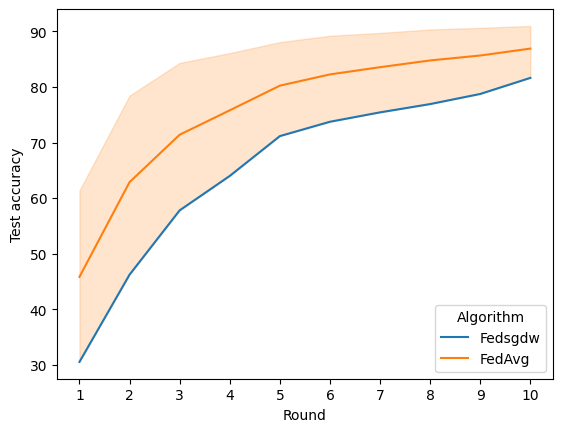

In [29]:
# Create a line plot of the accuracy after each round for the following algorithm variants:

# FedSGD
# FedAvg (E=1)
# FedAvg (E=2)
# FedAvg (E=4)
import pandas as pd
import seaborn as sns
#from tutorial_1a.hfl_complete import *

n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 10
iid = True
seed = 10
client_subsets = split(n, iid, seed)

fedsgd_server = FedSgdWServer(lr, b, client_subsets, c, e, seed)
result_fedsgd = fedsgd_server.run(nr_rounds)
fedsgdw_df = result_fedsgd.as_df()

fedavg_server1 = FedAvgServer(lr, b, client_subsets, c, e, seed)
result_fedavg1 = fedavg_server1.run(nr_rounds)
fedavge1_df = result_fedavg1.as_df()


fedavg_server2 = FedAvgServer(lr, b, client_subsets, c, 2, seed)
result_fedavg2 = fedavg_server2.run(nr_rounds)
fedavge2_df = result_fedavg2.as_df()


fedavg_server4 = FedAvgServer(lr, b, client_subsets, c, 4, seed)
result_fedavg4 = fedavg_server4.run(nr_rounds)
fedavge4_df = result_fedavg4.as_df()


df = pd.concat([fedsgdw_df, fedavge1_df,fedavge2_df,fedavge4_df], ignore_index=True)
ax = sns.lineplot(df, x="Round", y="Test accuracy", hue="Algorithm", seed=0)
_ = ax.set_xticks(df["Round"].unique())

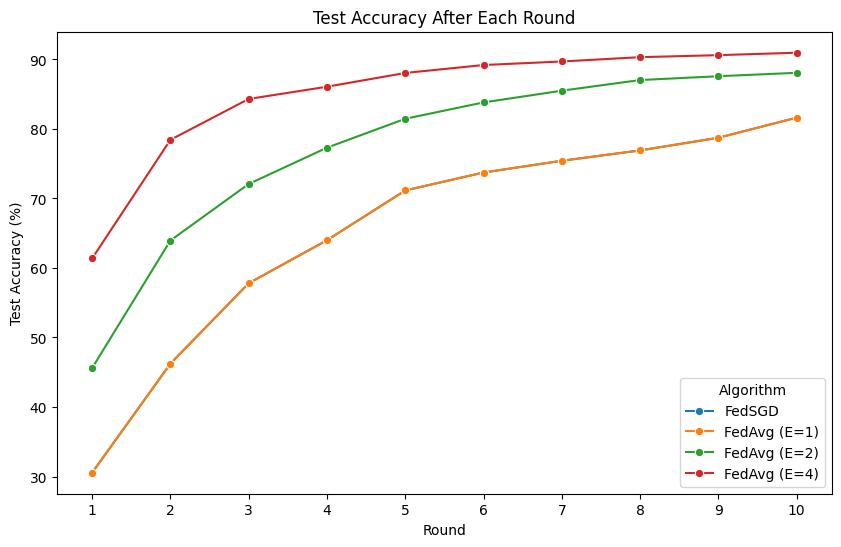

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add an 'Algorithm' column to each DataFrame
fedsgdw_df['Algorithm'] = 'FedSGD'
fedavge1_df['Algorithm'] = 'FedAvg (E=1)'
fedavge2_df['Algorithm'] = 'FedAvg (E=2)'
fedavge4_df['Algorithm'] = 'FedAvg (E=4)'

# Concatenate all DataFrames
df = pd.concat([fedsgdw_df, fedavge1_df, fedavge2_df, fedavge4_df], ignore_index=True)

# Plot the results
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df, x="Round", y="Test accuracy", hue="Algorithm", marker='o')
ax.set_xticks(df["Round"].unique())
ax.set_title('Test Accuracy After Each Round')
ax.set_xlabel('Round')
ax.set_ylabel('Test Accuracy (%)')
plt.legend(title='Algorithm')
plt.show()

TODO

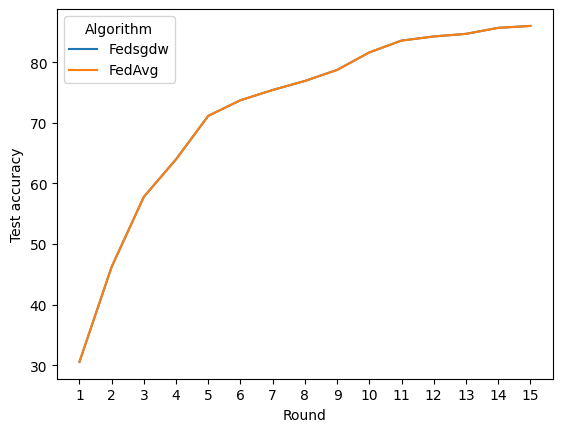

In [31]:
# FedSGD and FedAvg under an IID and non-IID split for 15 rounds


n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 15
iid = True
seed = 10
client_subsets = split(n, iid, seed)

fedsgd_server = FedSgdWServer(lr, b, client_subsets, c, e, seed)
result_fedsgd = fedsgd_server.run(nr_rounds)
fedsgdw_df = result_fedsgd.as_df()

fedavg_server1 = FedAvgServer(lr, b, client_subsets, c, e, seed)
result_fedavg1 = fedavg_server1.run(nr_rounds)
fedavg_df = result_fedavg1.as_df()

df = pd.concat([fedsgdw_df, fedavg_df], ignore_index=True)
ax = sns.lineplot(df, x="Round", y="Test accuracy", hue="Algorithm", seed=seed)
_ = ax.set_xticks(df["Round"].unique())



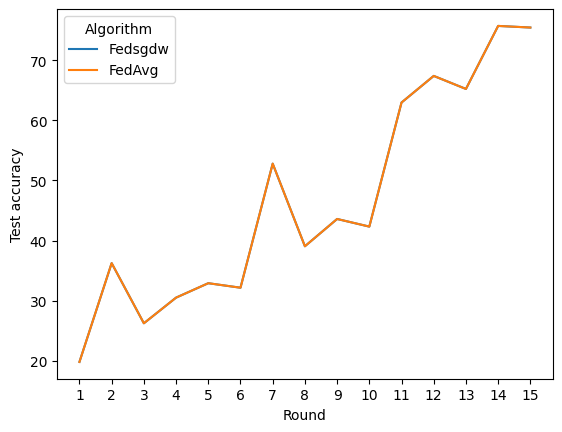

In [32]:
iid = False
client_subsets = split(n, iid, seed)
fedsgd_server = FedSgdWServer(lr, b, client_subsets, c, e, seed)
result_fedsgd = fedsgd_server.run(nr_rounds)
fedsgdw_df = result_fedsgd.as_df()

fedavg_server1 = FedAvgServer(lr, b, client_subsets, c, e, seed)
result_fedavg1 = fedavg_server1.run(nr_rounds)
fedavg_df = result_fedavg1.as_df()

df2 = pd.concat([fedsgdw_df, fedavg_df], ignore_index=True)
ax = sns.lineplot(df2, x="Round", y="Test accuracy", hue="Algorithm", seed=seed)
_ = ax.set_xticks(df["Round"].unique())

TODO

In [33]:
# only non-IID splits, including the FedSGD and FedAvg configs from before,
# and add a version for each with a learning rate of 0.001 and client fraction of 0.5.

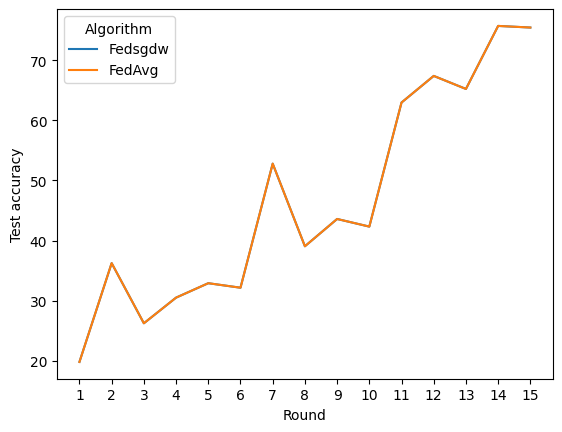

In [34]:

n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 15
seed = 10
iid = False
client_subsets = split(n, iid, seed)
fedsgd_server = FedSgdWServer(lr, b, client_subsets, c, e, seed)
result_fedsgd = fedsgd_server.run(nr_rounds)
fedsgdw_df = result_fedsgd.as_df()

fedavg_server1 = FedAvgServer(lr, b, client_subsets, c, e, seed)
result_fedavg1 = fedavg_server1.run(nr_rounds)
fedavg_df = result_fedavg1.as_df()

df = pd.concat([fedsgdw_df, fedavg_df], ignore_index=True)
ax = sns.lineplot(df, x="Round", y="Test accuracy", hue="Algorithm", seed=seed)
_ = ax.set_xticks(df["Round"].unique())


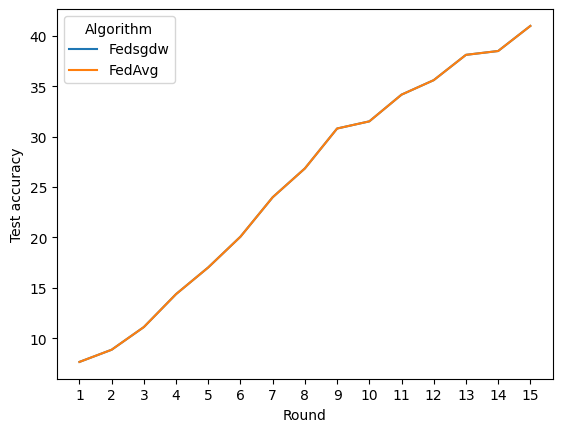

In [35]:


lr = 0.001
c = 0.5
client_subsets = split(n, iid, seed)

fedsgd_server = FedSgdWServer(lr, b, client_subsets, c, e, seed)
result_fedsgd = fedsgd_server.run(nr_rounds)
fedsgdw_df = result_fedsgd.as_df()

fedavg_server1 = FedAvgServer(lr, b, client_subsets, c, e, seed)
result_fedavg1 = fedavg_server1.run(nr_rounds)
fedavg_df = result_fedavg1.as_df()

df2 = pd.concat([fedsgdw_df, fedavg_df], ignore_index=True)
ax = sns.lineplot(df2, x="Round", y="Test accuracy", hue="Algorithm", seed=seed)
_ = ax.set_xticks(df["Round"].unique())

TODO

## Part B (12 points)

### Exercise B1: Microbatch Pipeline Model Parallelism (7 points)

Implement pipeline parallelism with microbatches, as discussed during the lab.

As with the other data/model parallelism examples, you will need a Python script for the nodes and a shell script to orchestrate execution.

Be aware of the possibility of deadlocks: due to how `gloo` operates, it is possible to deadlock by having device 1 send $B_2$ to device 2 in the forward pass, and simultaneously, device 2 send $B_1$ in the backward pass.
Since both operations will await a corresponding receive the training will stop indefinitely.

Use `isend` & `irecv`, the asynchronous (non-blocking) versions of `send` & `recv` in `torch.distributed`.
Add comments or text explaining how you expect your implementation to work and test that it runs for the same number of steps and model architecture as in class.

Note that `torch.distributed`'s implementation of `gloo` does not currently support properly asynchronous communication even when using the corresponding primitives.
Thus, you will not see the same improvements in speed as with a backend like `nccl`.

You may also take advantage of the fact that `torch` gradients naturally accumulate if zeroed out.
Also, scaling the loss by a constant is equivalent to scaling the resulting gradients by the same constant.

### Exercise B2: Joint Data & Model Parallelism (5 points)

Implement a training setup that uses data and model parallelism together.

Create 2 pipelines of 3 stages running sequentially, where each stage works with 3 sequential micro-batches.

Once again, add comments or text explaining your implementation and test it on the setting that mimics those from the class.

You can use groups from `torch.distributed` to handle operations that require interaction between a subset of more than two but less than all workers.